In [1]:
import numpy as np

from mpi4py import MPI
from petsc4py import PETSc

import dolfinx
import ufl
from basix.ufl import blocked_element, element, enriched_element, mixed_element
from dolfinx.fem import Function, functionspace, dirichletbc, Expression, locate_dofs_topological, Constant
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary, meshtags
from ufl import grad, inner, split
from dolfinx import plot, default_scalar_type
from dolfinx.nls.petsc import NewtonSolver
from tqdm import tqdm
import pyvista

# Simulation setup

In [2]:
nex = int(10)
ney = int(80)

#ele_type = "qua" 
#ele_type = "tri_enriched"
ele_type = "tri" 

if ele_type == "tri_enriched":
    cell_type = CellType.triangle
    enriched = True
elif ele_type == "tri":
    cell_type = CellType.triangle
    enriched = False
elif ele_type == "qua":
    cell_type = CellType.quadrilateral

In [3]:
from pathlib import Path

results_folder = Path(f"results/nonlinear_Naghdi/slit-annular-plate/{nex}_{ney}_{ele_type}")
results_folder.mkdir(exist_ok=True, parents=True)

pyvista.start_xvfb()

# Mesh

In [4]:
R0 = 6.0
dR = 4.0
Ra = R0 + dR/2

mesh = create_rectangle(MPI.COMM_WORLD, np.array([[0.0, 0.0], [dR, Ra*2*np.pi]]), 
                        [nex, ney], cell_type)
tdim = mesh.topology.dim
fdim = tdim - 1

## plot mesh

In [ ]:
topology, cell_types, geometry = plot.vtk_mesh(mesh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid, show_edges=True)
#plotter.show_grid()
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/f"mesh_rank{mesh.comm.rank}.png")

plotter.close()

# Material

In [5]:
E, nu = Constant(mesh, default_scalar_type(21.0E6)), Constant(mesh, default_scalar_type(0.0))
mu = E/(2.0*(1.0 + nu))
lmbda = 2.0*mu*nu/(1.0 - 2.0*nu)
t = Constant(mesh, default_scalar_type(3E-2))

# Initial shape

In [6]:
x = ufl.SpatialCoordinate(mesh)
phi0_ufl = ufl.as_vector([(R0 + x[0])*ufl.cos(x[1] / Ra),
                          (R0 + x[0])*ufl.sin(x[1] / Ra),
                          0])

def unit_normal(phi):
    n = ufl.cross(phi.dx(0), phi.dx(1))
    return n/ufl.sqrt(inner(n, n))

n0_ufl = unit_normal(phi0_ufl)

# for the 3 translation DOFs, we use the P2 + B3 enriched element
cell = mesh.basix_cell()
P2 = element("Lagrange", cell, degree=2)
B3 = element("Bubble", cell, degree=3)

def tangent_1(n):
    e2 = ufl.as_vector([0, 1, 0])
    t1 = ufl.cross(e2, n)
    t1 = t1/ufl.sqrt(inner(t1, t1))
    return t1

def tangent_2(n, t1):
    t2 = ufl.cross(n, t1)
    t2 = t2/ufl.sqrt(inner(t2, t2))
    return t2

# the analytical expression of t1 and t2
t1_ufl = tangent_1(n0_ufl)
t2_ufl = tangent_2(n0_ufl, t1_ufl)

# the analytical expression of R0
def rotation_matrix(t1, t2, n):
    R = ufl.as_matrix([[t1[0], t2[0], n[0]], 
                       [t1[1], t2[1], n[1]], 
                       [t1[2], t2[2], n[2]]])
    return R

R0_ufl = rotation_matrix(t1_ufl, t2_ufl, n0_ufl)

# Update the director with two successive elementary rotations
def director(R0, theta):
    Lm3 = ufl.as_vector([ufl.sin(theta[1])*ufl.cos(theta[0]), -ufl.sin(theta[0]), ufl.cos(theta[1])*ufl.cos(theta[0])])
    d = ufl.dot(R0, Lm3)
    return d

## plot initial shape

In [ ]:
# create a FEM interpolation of n0 and phi0
P1_d3_FS = functionspace(mesh, element("Lagrange", cell, degree = 1, shape = (3,)))

n0_P1_expr = Expression(n0_ufl, P1_d3_FS.element.interpolation_points())
n0_P1_func = Function(P1_d3_FS)
n0_P1_func.interpolate(n0_P1_expr)

phi0_P1_expr = Expression(phi0_ufl, P1_d3_FS.element.interpolation_points())
phi0_P1_func = Function(P1_d3_FS)
phi0_P1_func.interpolate(phi0_P1_expr)

topology, cell_types, geometry = plot.vtk_mesh(P1_d3_FS)

geometry_phi0_P1 = phi0_P1_func.x.array.reshape((geometry.shape[0], len(phi0_P1_func)))
geometry_n0_P1 = n0_P1_func.x.array.reshape((geometry.shape[0], len(n0_P1_func)))

grid_phi0_P1 = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi0_P1)
grid_phi0_P1["n0"] = geometry_n0_P1
glyphs = grid_phi0_P1.glyph(orient="n0", factor=1)


plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid_phi0_P1, style="wireframe", color="k")
plotter.add_mesh(glyphs,  show_scalar_bar=True, scalar_bar_args={"vertical": True})
plotter.show_grid()
plotter.enable_parallel_projection()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/f"initial_shape_rank{mesh.comm.rank}.png")
    
plotter.close()

# Shell element

In [7]:
if ele_type == "tri_enriched":
    P2B3 = enriched_element([P2, B3])
    naghdi_shell_element = mixed_element(
        [blocked_element(P2B3, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
elif ele_type == "tri":
        naghdi_shell_element = mixed_element(
            [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
        )
    
elif ele_type == "qua":
    naghdi_shell_element = mixed_element(
        [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
    
naghdi_shell_FS = functionspace(mesh, naghdi_shell_element)

q_func = Function(naghdi_shell_FS) # current configuration
q_trial = ufl.TrialFunction(naghdi_shell_FS)
q_test = ufl.TestFunction(naghdi_shell_FS)

u_func, theta_func = split(q_func) # current displacement and rotation

# Shell model

In [8]:
# current deformation gradient 
F = grad(u_func) + grad(phi0_ufl) 

# current director
d = director(R0_ufl, theta_func)

# initial metric and curvature tensor a0 and b0
a0_ufl = grad(phi0_ufl).T * grad(phi0_ufl)
b0_ufl = -0.5*( grad(phi0_ufl).T * grad(n0_ufl) + grad(n0_ufl).T * grad(phi0_ufl))

def epsilon(F):
    """Membrane strain"""
    return 0.5 * (F.T * F - a0_ufl)


def kappa(F, d):
    """Bending strain"""
    return -0.5 * (F.T * grad(d) + grad(d).T * F) - b0_ufl


def gamma(F, d):
    """Transverse shear strain"""
    return F.T * d

a0_contra_ufl = ufl.inv(a0_ufl)
j0_ufl = ufl.det(a0_ufl)

i,j,l,m = ufl.indices(4)  # noqa: E741
A_contra_ufl = ufl.as_tensor( ( ((2.0*lmbda*mu) / (lmbda + 2.0*mu)) * a0_contra_ufl[i,j]*a0_contra_ufl[l,m]
                + 1.0*mu* (a0_contra_ufl[i,l]*a0_contra_ufl[j,m] + a0_contra_ufl[i,m]*a0_contra_ufl[j,l]) )
                ,[i,j,l,m])

N = ufl.as_tensor(t * A_contra_ufl[i,j,l,m] * epsilon(F)[l,m], [i,j])

M = ufl.as_tensor( (t**3 / 12.0) * A_contra_ufl[i,j,l,m]*kappa(F, d)[l,m], [i,j])

T = ufl.as_tensor( (t * mu *5.0 / 6.0) * a0_contra_ufl[i, j] * gamma(F, d)[j], [i])

psi_m = 0.5*inner(N, epsilon(F))

psi_b = 0.5*inner(M, kappa(F, d))

psi_s = 0.5*inner(T, gamma(F, d))

# External work

In [9]:
def free_end(x):
    return np.isclose(x[1], 0.0)


def fixed_end(x):
    return np.isclose(x[1], Ra*2*np.pi)

free_facets = locate_entities_boundary(mesh, fdim, free_end)
fixed_facets = locate_entities_boundary(mesh, fdim, fixed_end)

# left facets are marked with tag 1, right facets are marked with tag 2
marked_facets = np.hstack([free_facets, fixed_facets])
marked_values = np.hstack([np.full_like(free_facets, 2), np.full_like(fixed_facets, 1)])
sorted_facets = np.argsort(marked_facets)
facet_tag = meshtags(mesh, fdim, marked_facets[sorted_facets], marked_values[sorted_facets])

P_right = Constant(mesh, default_scalar_type(0.0))

ds = ufl.Measure("ds", domain=mesh, subdomain_data=facet_tag, metadata={"quadrature_degree": 2})

W_ext = P_right * u_func[2] * ds(2)

# Potential energy with PSRI

In [10]:
# Full integration of order 4
dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})

# Reduced integration of order 2
dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})

# Calculate the factor alpha as a function of the mesh size h
h = ufl.CellDiameter(mesh)
alpha_FS = functionspace(mesh, element("DG", cell, 0))
alpha_expr = Expression(t**2 / h**2, alpha_FS.element.interpolation_points())
alpha = Function(alpha_FS)
alpha.interpolate(alpha_expr)

# Full integration part of the total elastic energy
Pi_PSRI = psi_b * ufl.sqrt(j0_ufl) * dx_f 
Pi_PSRI += alpha * psi_m * ufl.sqrt(j0_ufl) * dx_f
Pi_PSRI += alpha * psi_s * ufl.sqrt(j0_ufl) * dx_f

# Reduced integration part of the total elastic energy
Pi_PSRI += (1.0 - alpha) * psi_m * ufl.sqrt(j0_ufl) * dx_r
Pi_PSRI += (1.0 - alpha) * psi_s * ufl.sqrt(j0_ufl) * dx_r

# external work part
Pi_PSRI -= W_ext

Residual = ufl.derivative(Pi_PSRI, q_func, q_test)
Jacobian = ufl.derivative(Residual, q_func, q_trial)

# clamped boundary condtions

In [11]:
u_FS, _ = naghdi_shell_FS.sub(0).collapse()
theta_FS, _ = naghdi_shell_FS.sub(1).collapse()

# u1, u2, u3 = 0 on the clamped boundary
u_clamped = Function(u_FS) # default value is 0
clamped_dofs_u = locate_dofs_topological((naghdi_shell_FS.sub(0), u_FS), fdim, facet_tag.find(1))
bc_clamped_u = dirichletbc(u_clamped, clamped_dofs_u, naghdi_shell_FS.sub(0))

# theta1, theta2 = 0 on the clamped boundary
theta_clamped = Function(theta_FS) # default value is 0
clamped_dofs_theta = locate_dofs_topological((naghdi_shell_FS.sub(1), theta_FS), fdim, facet_tag.find(1))
bc_clamped_theta = dirichletbc(theta_clamped, clamped_dofs_theta, naghdi_shell_FS.sub(1))

bcs = [bc_clamped_u, bc_clamped_theta]

# bb tree

In [12]:
bb_tree = dolfinx.geometry.bb_tree(mesh, 2)
bb_point_A = np.array([[0.0, 0.0, 0.0]], dtype=np.float64)
bb_point_B = np.array([[dR, 0.0, 0.0]], dtype=np.float64)
# Find the leaf that the target point is in
bb_cell_candidates_A = dolfinx.geometry.compute_collisions_points(bb_tree, bb_point_A)
bb_cell_candidates_B = dolfinx.geometry.compute_collisions_points(bb_tree, bb_point_B)

# Find the cell from the leaf that contains the target point
bb_cells_A = dolfinx.geometry.compute_colliding_cells(
    mesh, bb_cell_candidates_A, bb_point_A)
bb_cells_B = dolfinx.geometry.compute_colliding_cells(
    mesh, bb_cell_candidates_B, bb_point_B)

# Newton solver

In [13]:
problem = NonlinearProblem(Residual, q_func, bcs, Jacobian)
solver = NewtonSolver(mesh.comm, problem)

# Set Newton solver options
solver.rtol = 1e-6
solver.atol = 1e-6
solver.max_it = 30
solver.convergence_criterion = "incremental"
solver.report = True

# Modify the linear solver in each Newton iteration
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

In [14]:
P_max = 0.8
nstep = 100
Ps = np.linspace(0.0, P_max, nstep)

if mesh.comm.rank == 0:
    WA_list = np.zeros(nstep)
    WB_list = np.zeros(nstep)
    
file_u = dolfinx.io.VTKFile(mesh.comm, results_folder/"u.pvd", "w")
file_theta = dolfinx.io.VTKFile(mesh.comm, results_folder/"theta.pvd", "w")
file_phi = dolfinx.io.VTKFile(mesh.comm, results_folder/"phi.pvd", "w")
 
q_func.x.array[:] = 0.0

#dolfinx.log.set_log_level(dolfinx.log.LogLevel.INFO)
#dolfinx.log.set_log_level(dolfinx.log.LogLevel.OFF)

for i, P_curr in enumerate(tqdm(Ps)):
    P_right.value = P_curr
    n, converged = solver.solve(q_func)
    assert (converged)
    q_func.x.scatter_forward()
    if mesh.comm.rank == 0:
        print(f"Load step {i:d}, Number of iterations: {n:d}, Load: {P_curr / P_max:.2f}", flush=True)
    
    # write output
    phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
    if ele_type == "tri_enriched":
        u_P2B3 = q_func.sub(0).collapse()
        u_P2 = Function(phi_FS)
        u_P2.interpolate(u_P2B3)
    else:
        u_P2 = q_func.sub(0).collapse()
    
    phi_expr = Expression(phi0_ufl + u_P2, phi_FS.element.interpolation_points())
    phi_func = Function(phi_FS)
    phi_func.interpolate(phi_expr)
    theta_P2 = q_func.sub(1).collapse()

    file_u.write_function(u_P2, i)
    file_theta.write_function(theta_P2, i)
    file_phi.write_function(phi_func, i)
    
    # calculate u3 at the point load
    WA_bb = None
    WB_bb = None
    u3_func = q_func.sub(0).sub(2).collapse()
    
    if len(bb_cells_A.array) > 0:
        WA_bb = u3_func.eval(bb_point_A, bb_cells_A.array[0])[0]
    WA_bb = mesh.comm.gather(WA_bb, root=0)
    
    if len(bb_cells_B.array) > 0:
        WB_bb = u3_func.eval(bb_point_B, bb_cells_B.array[0])[0]
    WB_bb = mesh.comm.gather(WB_bb, root=0)
    
    if mesh.comm.rank == 0:
        for WA in WA_bb:
            if WA is not None:
                WA_list[i] = WA
                break
            
        for WB in WB_bb:
            if WB is not None:
                WB_list[i] = WB
                break

# close the output files
file_u.close()
file_theta.close()
file_phi.close()

  0%|          | 0/100 [00:00<?, ?it/s]

Load step 0, Number of iterations: 2, Load: 0.00


  1%|          | 1/100 [00:00<01:11,  1.39it/s]

Load step 1, Number of iterations: 10, Load: 0.01


  2%|▏         | 2/100 [00:03<03:05,  1.90s/it]

Load step 2, Number of iterations: 9, Load: 0.02


  3%|▎         | 3/100 [00:05<03:21,  2.07s/it]

Load step 3, Number of iterations: 9, Load: 0.03


  4%|▍         | 4/100 [00:07<03:22,  2.11s/it]

Load step 4, Number of iterations: 9, Load: 0.04


  5%|▌         | 5/100 [00:10<03:20,  2.11s/it]

Load step 5, Number of iterations: 9, Load: 0.05


  6%|▌         | 6/100 [00:12<03:25,  2.18s/it]

Load step 6, Number of iterations: 9, Load: 0.06


  7%|▋         | 7/100 [00:14<03:22,  2.18s/it]

Load step 7, Number of iterations: 9, Load: 0.07


  8%|▊         | 8/100 [00:16<03:20,  2.18s/it]

Load step 8, Number of iterations: 9, Load: 0.08


  9%|▉         | 9/100 [00:18<03:18,  2.18s/it]

Load step 9, Number of iterations: 8, Load: 0.09


 10%|█         | 10/100 [00:20<03:12,  2.14s/it]

Load step 10, Number of iterations: 8, Load: 0.10


 11%|█         | 11/100 [00:22<03:01,  2.04s/it]

Load step 11, Number of iterations: 8, Load: 0.11


 12%|█▏        | 12/100 [00:24<02:55,  1.99s/it]

Load step 12, Number of iterations: 8, Load: 0.12


 13%|█▎        | 13/100 [00:26<02:51,  1.97s/it]

Load step 13, Number of iterations: 8, Load: 0.13


 14%|█▍        | 14/100 [00:28<02:51,  2.00s/it]

Load step 14, Number of iterations: 8, Load: 0.14


 15%|█▌        | 15/100 [00:30<02:56,  2.08s/it]

Load step 15, Number of iterations: 7, Load: 0.15


 16%|█▌        | 16/100 [00:32<02:43,  1.95s/it]

Load step 16, Number of iterations: 7, Load: 0.16


 17%|█▋        | 17/100 [00:34<02:34,  1.86s/it]

Load step 17, Number of iterations: 7, Load: 0.17


 18%|█▊        | 18/100 [00:35<02:30,  1.83s/it]

Load step 18, Number of iterations: 7, Load: 0.18


 19%|█▉        | 19/100 [00:37<02:23,  1.77s/it]

Load step 19, Number of iterations: 7, Load: 0.19


 20%|██        | 20/100 [00:39<02:19,  1.75s/it]

Load step 20, Number of iterations: 6, Load: 0.20


 21%|██        | 21/100 [00:40<02:11,  1.67s/it]

Load step 21, Number of iterations: 6, Load: 0.21


 22%|██▏       | 22/100 [00:42<02:07,  1.63s/it]

Load step 22, Number of iterations: 6, Load: 0.22


 23%|██▎       | 23/100 [00:43<02:01,  1.58s/it]

Load step 23, Number of iterations: 6, Load: 0.23


 24%|██▍       | 24/100 [00:45<01:56,  1.53s/it]

Load step 24, Number of iterations: 6, Load: 0.24


 25%|██▌       | 25/100 [00:46<01:52,  1.50s/it]

Load step 25, Number of iterations: 6, Load: 0.25


 26%|██▌       | 26/100 [00:48<01:52,  1.52s/it]

Load step 26, Number of iterations: 6, Load: 0.26


 27%|██▋       | 27/100 [00:49<01:49,  1.49s/it]

Load step 27, Number of iterations: 6, Load: 0.27


 28%|██▊       | 28/100 [00:50<01:45,  1.47s/it]

Load step 28, Number of iterations: 6, Load: 0.28


 29%|██▉       | 29/100 [00:52<01:43,  1.46s/it]

Load step 29, Number of iterations: 6, Load: 0.29


 30%|███       | 30/100 [00:53<01:44,  1.49s/it]

Load step 30, Number of iterations: 6, Load: 0.30


 31%|███       | 31/100 [00:55<01:42,  1.48s/it]

Load step 31, Number of iterations: 6, Load: 0.31


 32%|███▏      | 32/100 [00:56<01:39,  1.46s/it]

Load step 32, Number of iterations: 6, Load: 0.32


 33%|███▎      | 33/100 [00:58<01:38,  1.48s/it]

Load step 33, Number of iterations: 6, Load: 0.33


 34%|███▍      | 34/100 [00:59<01:38,  1.49s/it]

Load step 34, Number of iterations: 6, Load: 0.34


 35%|███▌      | 35/100 [01:01<01:36,  1.49s/it]

Load step 35, Number of iterations: 6, Load: 0.35


 36%|███▌      | 36/100 [01:02<01:35,  1.49s/it]

Load step 36, Number of iterations: 6, Load: 0.36


 37%|███▋      | 37/100 [01:04<01:34,  1.50s/it]

Load step 37, Number of iterations: 6, Load: 0.37


 38%|███▊      | 38/100 [01:06<01:35,  1.54s/it]

Load step 38, Number of iterations: 5, Load: 0.38


 39%|███▉      | 39/100 [01:07<01:27,  1.44s/it]

Load step 39, Number of iterations: 5, Load: 0.39


 40%|████      | 40/100 [01:08<01:23,  1.39s/it]

Load step 40, Number of iterations: 5, Load: 0.40


 41%|████      | 41/100 [01:09<01:18,  1.34s/it]

Load step 41, Number of iterations: 5, Load: 0.41


 42%|████▏     | 42/100 [01:10<01:15,  1.30s/it]

Load step 42, Number of iterations: 5, Load: 0.42


 43%|████▎     | 43/100 [01:12<01:13,  1.28s/it]

Load step 43, Number of iterations: 5, Load: 0.43


 44%|████▍     | 44/100 [01:13<01:11,  1.28s/it]

Load step 44, Number of iterations: 5, Load: 0.44


 45%|████▌     | 45/100 [01:14<01:09,  1.26s/it]

Load step 45, Number of iterations: 5, Load: 0.45


 46%|████▌     | 46/100 [01:15<01:07,  1.25s/it]

Load step 46, Number of iterations: 5, Load: 0.46


 47%|████▋     | 47/100 [01:17<01:06,  1.25s/it]

Load step 47, Number of iterations: 5, Load: 0.47


 48%|████▊     | 48/100 [01:18<01:05,  1.25s/it]

Load step 48, Number of iterations: 5, Load: 0.48


 49%|████▉     | 49/100 [01:19<01:05,  1.29s/it]

Load step 49, Number of iterations: 5, Load: 0.49


 50%|█████     | 50/100 [01:21<01:04,  1.30s/it]

Load step 50, Number of iterations: 5, Load: 0.51


 51%|█████     | 51/100 [01:22<01:02,  1.28s/it]

Load step 51, Number of iterations: 5, Load: 0.52


 52%|█████▏    | 52/100 [01:23<01:01,  1.29s/it]

Load step 52, Number of iterations: 5, Load: 0.53


 53%|█████▎    | 53/100 [01:24<01:00,  1.29s/it]

Load step 53, Number of iterations: 5, Load: 0.54


 54%|█████▍    | 54/100 [01:26<00:58,  1.28s/it]

Load step 54, Number of iterations: 5, Load: 0.55


 55%|█████▌    | 55/100 [01:27<00:57,  1.27s/it]

Load step 55, Number of iterations: 5, Load: 0.56


 56%|█████▌    | 56/100 [01:28<00:55,  1.26s/it]

Load step 56, Number of iterations: 5, Load: 0.57


 57%|█████▋    | 57/100 [01:29<00:54,  1.27s/it]

Load step 57, Number of iterations: 5, Load: 0.58


 58%|█████▊    | 58/100 [01:31<00:52,  1.24s/it]

Load step 58, Number of iterations: 5, Load: 0.59


 59%|█████▉    | 59/100 [01:32<00:50,  1.23s/it]

Load step 59, Number of iterations: 5, Load: 0.60


 60%|██████    | 60/100 [01:33<00:49,  1.23s/it]

Load step 60, Number of iterations: 5, Load: 0.61


 61%|██████    | 61/100 [01:34<00:47,  1.23s/it]

Load step 61, Number of iterations: 5, Load: 0.62


 62%|██████▏   | 62/100 [01:36<00:47,  1.25s/it]

Load step 62, Number of iterations: 5, Load: 0.63


 63%|██████▎   | 63/100 [01:37<00:46,  1.26s/it]

Load step 63, Number of iterations: 5, Load: 0.64


 64%|██████▍   | 64/100 [01:38<00:45,  1.26s/it]

Load step 64, Number of iterations: 5, Load: 0.65


 65%|██████▌   | 65/100 [01:39<00:43,  1.23s/it]

Load step 65, Number of iterations: 5, Load: 0.66


 66%|██████▌   | 66/100 [01:41<00:41,  1.23s/it]

Load step 66, Number of iterations: 5, Load: 0.67


 67%|██████▋   | 67/100 [01:42<00:40,  1.24s/it]

Load step 67, Number of iterations: 5, Load: 0.68


 68%|██████▊   | 68/100 [01:43<00:39,  1.24s/it]

Load step 68, Number of iterations: 5, Load: 0.69


 69%|██████▉   | 69/100 [01:44<00:38,  1.24s/it]

Load step 69, Number of iterations: 5, Load: 0.70


 70%|███████   | 70/100 [01:46<00:37,  1.25s/it]

Load step 70, Number of iterations: 5, Load: 0.71


 71%|███████   | 71/100 [01:47<00:35,  1.24s/it]

Load step 71, Number of iterations: 5, Load: 0.72


 72%|███████▏  | 72/100 [01:48<00:35,  1.28s/it]

Load step 72, Number of iterations: 4, Load: 0.73


 73%|███████▎  | 73/100 [01:49<00:32,  1.19s/it]

Load step 73, Number of iterations: 4, Load: 0.74


 74%|███████▍  | 74/100 [01:50<00:29,  1.14s/it]

Load step 74, Number of iterations: 4, Load: 0.75


 75%|███████▌  | 75/100 [01:51<00:27,  1.09s/it]

Load step 75, Number of iterations: 4, Load: 0.76


 76%|███████▌  | 76/100 [01:52<00:25,  1.06s/it]

Load step 76, Number of iterations: 4, Load: 0.77


 77%|███████▋  | 77/100 [01:53<00:24,  1.06s/it]

Load step 77, Number of iterations: 4, Load: 0.78


 78%|███████▊  | 78/100 [01:54<00:23,  1.05s/it]

Load step 78, Number of iterations: 4, Load: 0.79


 79%|███████▉  | 79/100 [01:55<00:21,  1.04s/it]

Load step 79, Number of iterations: 4, Load: 0.80


 80%|████████  | 80/100 [01:56<00:20,  1.03s/it]

Load step 80, Number of iterations: 4, Load: 0.81


 81%|████████  | 81/100 [01:57<00:19,  1.03s/it]

Load step 81, Number of iterations: 4, Load: 0.82


 82%|████████▏ | 82/100 [01:58<00:18,  1.02s/it]

Load step 82, Number of iterations: 4, Load: 0.83


 83%|████████▎ | 83/100 [01:59<00:17,  1.01s/it]

Load step 83, Number of iterations: 4, Load: 0.84


 84%|████████▍ | 84/100 [02:00<00:15,  1.00it/s]

Load step 84, Number of iterations: 4, Load: 0.85


 85%|████████▌ | 85/100 [02:01<00:15,  1.01s/it]

Load step 85, Number of iterations: 4, Load: 0.86


 86%|████████▌ | 86/100 [02:02<00:14,  1.01s/it]

Load step 86, Number of iterations: 4, Load: 0.87


 87%|████████▋ | 87/100 [02:03<00:13,  1.02s/it]

Load step 87, Number of iterations: 4, Load: 0.88


 88%|████████▊ | 88/100 [02:04<00:12,  1.03s/it]

Load step 88, Number of iterations: 4, Load: 0.89


 89%|████████▉ | 89/100 [02:05<00:11,  1.02s/it]

Load step 89, Number of iterations: 4, Load: 0.90


 90%|█████████ | 90/100 [02:06<00:10,  1.01s/it]

Load step 90, Number of iterations: 4, Load: 0.91


 91%|█████████ | 91/100 [02:07<00:09,  1.02s/it]

Load step 91, Number of iterations: 4, Load: 0.92


 92%|█████████▏| 92/100 [02:08<00:08,  1.01s/it]

Load step 92, Number of iterations: 4, Load: 0.93


 93%|█████████▎| 93/100 [02:09<00:07,  1.02s/it]

Load step 93, Number of iterations: 4, Load: 0.94


 94%|█████████▍| 94/100 [02:10<00:06,  1.01s/it]

Load step 94, Number of iterations: 4, Load: 0.95


 95%|█████████▌| 95/100 [02:11<00:05,  1.02s/it]

Load step 95, Number of iterations: 4, Load: 0.96


 96%|█████████▌| 96/100 [02:12<00:04,  1.03s/it]

Load step 96, Number of iterations: 4, Load: 0.97


 97%|█████████▋| 97/100 [02:13<00:03,  1.02s/it]

Load step 97, Number of iterations: 4, Load: 0.98


 98%|█████████▊| 98/100 [02:14<00:02,  1.01s/it]

Load step 98, Number of iterations: 4, Load: 0.99


 99%|█████████▉| 99/100 [02:15<00:01,  1.02s/it]

Load step 99, Number of iterations: 4, Load: 1.00


100%|██████████| 100/100 [02:17<00:00,  1.37s/it]


## plot

In [15]:
u_sol = q_func.sub(0).collapse()

phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
phi_expr = Expression(phi0_ufl + u_sol, phi_FS.element.interpolation_points())
phi_func = Function(phi_FS)
phi_func.interpolate(phi_expr)

topology, cell_types, geometry = plot.vtk_mesh(phi_FS)

geometry_phi = phi_func.x.array.reshape((geometry.shape[0], len(phi_func)))

grid_phi = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi)

plotter = pyvista.Plotter()
plotter.add_mesh(grid_phi, style="wireframe", color="k")
plotter.show_grid()
plotter.enable_parallel_projection()
plotter.show_axes_all()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/"phi.png")
plotter.close()

Widget(value='<iframe src="http://localhost:37845/index.html?ui=P_0x7f5d889d9ac0_0&reconnect=auto" class="pyvi…

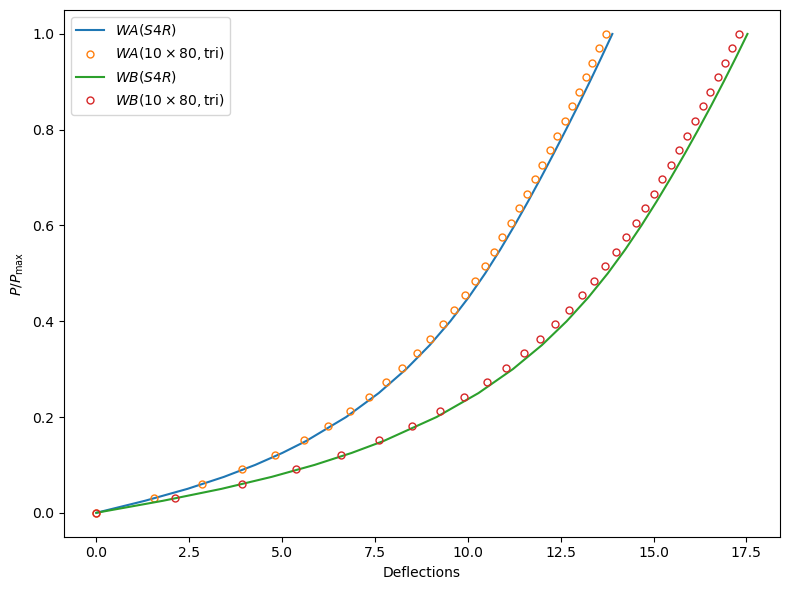

In [16]:
import matplotlib.pyplot as plt

if mesh.comm.rank == 0:
    P_S4R = np.array([0.00, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150, 
                      0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
                      0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85,
                      0.90, 0.95, 1.00])
    
    WA_S4R = np.array([0.00, 1.305, 2.455, 3.435, 4.277, 5.007, 5.649, 6.725, 7.602,
                       8.340, 8.974, 9.529, 10.023, 10.468, 10.876, 11.257, 11.620,
                       11.970, 12.310, 12.642, 12.966, 13.282, 13.590, 13.891])
    
    WB_S4R = np.array([0.00, 1.789, 3.370, 4.720, 5.876, 6.872, 7.736, 9.160, 10.288,
                       11.213, 11.992, 12.661, 13.247, 13.768, 14.240, 14.674, 15.081,
                       15.469, 15.842, 16.202, 16.550, 16.886, 17.212, 17.528])
    
    np.savetxt(results_folder/"WA.txt", WA_list)
    np.savetxt(results_folder/"WB.txt", WB_list)
    np.savetxt(results_folder/"Ps_Pmax.txt", Ps/P_max)
    
    fig = plt.figure(figsize=(8.0, 6.0))
    plt.plot(WA_S4R, P_S4R, "-", label="$WA(S4R)$")
    plt.plot(WA_list, Ps/P_max, "o", markersize=5, markerfacecolor='none',
             markevery = 3, label=f"$WA({nex}\\times{ney},${ele_type})")
    plt.plot(WB_S4R, P_S4R, "-", label="$WB(S4R)$")
    plt.plot(WB_list, Ps/P_max, "o", markersize=5, markerfacecolor='none',
             markevery = 3, label=f"$WB({nex}\\times{ney},${ele_type})")
    plt.ylabel(r"$P/P_{\mathrm{max}}$")
    plt.xlabel("Deflections")
    plt.legend()
    plt.tight_layout()
    plt.savefig(results_folder/"comparisons.png", dpi=300)